In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
import torch
from torch_geometric.data import Data, DataLoader
import torch.nn.functional as F
from torch_geometric.nn import dense_diff_pool
from torch import Tensor
from typing import Tuple

from torch_geometric.utils import to_networkx, negative_sampling
import networkx as nx

In [4]:
import utils.torchUtils as gnn
from utils.torchUtils.cpp_geometric import layers

In [5]:
dout='simple_pair'

In [6]:
gnn.config.set_gpu(0)

In [7]:
from torch_scatter import scatter_max
from torch_geometric.data import Batch
from torch.utils.data import Sampler


In [8]:
from utils.torchUtils.gnn import sample_pair
from utils.torchUtils import BaseTransform

In [9]:
subset='top8btag'

In [10]:
import utils.torchUtils as gnn 

transform = None
transform = gnn.Transform(gnn.SimplePair())
template = gnn.Dataset(f'../data/template',make_template=True, transform=transform)

sampler = None
sampler = gnn.Require8B

def load_training(fn=f'../data/{subset}/MX_1000_MY_450-training', template=None):
    transform = template.transform
    dataset = gnn.Dataset(fn,transform=transform)[:18000]
    training, validation = gnn.train_test_split(dataset, 0.2)
    # training, validation = dataset[1800:], dataset[:1800]

    batch_size = 100
    trainloader = DataLoader(training, batch_size=batch_size, num_workers=gnn.config.ncpu)
    validloader = DataLoader(validation, batch_size=batch_size, num_workers=gnn.config.ncpu)
    return trainloader, validloader

def load_testing(fn=f'../data/{subset}/MX_1000_MY_450-testing', template=None):
    transform = template.transform
    sample = gnn.Dataset(fn, transform=transform)[:1000]
    # sample = [ data for data in sample if data.edge_y.sum() > 0 ]
    batch_size = 100
    testloader = DataLoader(sample, batch_size=batch_size, num_workers=gnn.config.ncpu)
    return testloader
testloader = load_testing(template=template)
trainloader, validloader  = load_training(template=template)

In [11]:
data = next(data for data in validloader.dataset)

In [12]:
data

Data(x=[8, 5], edge_index=[2, 64], edge_attr=[64, 5], y=[8], edge_y=[64], node_id=[8], edge_id=[64], pos_mask_index=[1, 64], neg_mask_index=[8, 64])

(<Figure size 384x360 with 1 Axes>, <AxesSubplot:>)

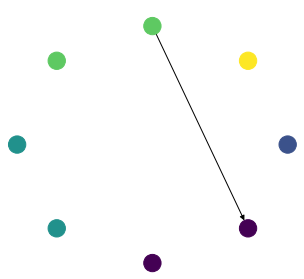

In [13]:
gnn.draw_data(data, data.neg_mask_index[3]==1,)

In [14]:
# loss='mismatched_bjet_loss'
loss='std_loss'
model = gnn.modelMap['simple_pair'](dataset=template, loss=loss,  nn_embed_1=32, nn_embed_2=64, nn_out_1=32, nn_out_2=16)

In [15]:
for batch in trainloader: batch

In [16]:
from pytorch_lightning import Trainer

trainer = Trainer(max_epochs=10, gpus=1*gnn.config.ngpu)
trainer.fit(model, trainloader, validloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
2022-05-31 11:18:02.367752: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-31 11:18:02.367803: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.

  | Name       | Type             | Params
------------------------------------------------
0 | f_loss     | CrossEntropyLoss | 0     
1 | node_embed | Linear           | 768   
2 | edge_embed | Linear           | 768   
3 | pair_1     | PairPredictor    | 98.6 K
4 | readout    | Sequential       | 41.3 K
------------------------------------------------
141 K     Trainable params
0         Non-trainable params
141 K     Total params
0.566     Total estimated model params size (MB)


Epoch 7:  73%|███████▎  | 132/180 [00:23<00:08,  5.56it/s, loss=0.901, v_num=20]

In [ ]:
trainer.test(model, validloader);

Testing: 100%|██████████| 4/4 [00:01<00:00,  4.26it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'auroc/test': 0.765625, 'hitk1/test': 0.25, 'loss/test': 1.1645050048828125}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


In [ ]:
def select_quadH(data):
    quadH_index = eightb.get_quadH_pairings()
    dijets = torch.combinations(torch.arange(data.num_nodes), 2)
    best_index = quadH_index[data.rank_o[quadH_index].sum(dim=-1).argmin()]
    return dijets[best_index].T


In [ ]:
def select_dijets(data):
    dijets = torch.combinations(torch.arange(data.num_nodes), 2)
    rank_o = data.rank_o
    selection = torch.LongTensor().reshape(2,0)
    for _ in range(4):
        top_dijet = dijets[rank_o.argmin()]
        selection = torch.cat([selection,top_dijet.reshape(2,1)],dim=-1)
        mask = (dijets.unsqueeze(2) != top_dijet).all(dim=-1).all(dim=-1)
        rank_o = rank_o[mask]
        dijets = dijets[mask]
    return selection

In [ ]:
class predict_data(gnn.BaseTransform):
    def __init__(self, model=model):
        super().__init__()
        self.model = model.to('cpu')
    def transform(self, data : Data) -> Data:
        data.pair_mask = data.edge_index[0] < data.edge_index[1]
        edge_o = self.model.predict(data)
        min_o, max_o = edge_o.min(), edge_o.max()
        data.edge_o = (edge_o-min_o)/(max_o+min_o)
        data.rank_o = data.edge_o.argsort(descending=True).argsort()

        # data.best_index = select_dijets(data)
        data.best_index = select_quadH(data)

        best_y = (data.node_id[data.best_index]+1)//2
        data.best_y = 1*(best_y[0] == best_y[1])
        return data

In [ ]:
gnn.config.set_gpu(0)

In [ ]:
def load_testing(fn=f'../data/{subset}/MX_1000_MY_450-testing', template=None):
    transform = template.transform + predict_data() + gnn.to_uptri_graph()
    sample = gnn.Dataset(fn, transform=transform)[:5000]
    batch_size = 1
    testloader = DataLoader(sample, batch_size=batch_size, num_workers=gnn.config.ncpu)
    return testloader
testloader = load_testing(template=template)

In [ ]:
subset = [ data for data in testloader.dataset if testloader.sampler(data) ]

In [ ]:
data = subset[0]

In [ ]:
n_best = torch.LongTensor([ data.best_y.sum() for data in subset ])

(<Figure size 384x360 with 1 Axes>, <AxesSubplot:ylabel='PDF'>)

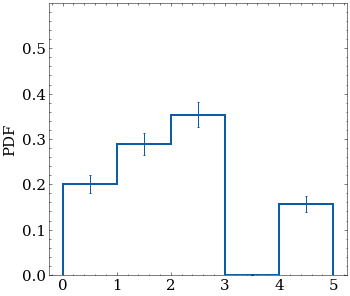

In [ ]:
hist_multi([n_best], density=True)

(<Figure size 384x360 with 1 Axes>, <AxesSubplot:ylabel='PDF'>)

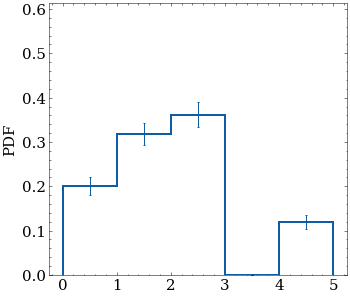

In [ ]:
hist_multi([n_best], density=True)